# **Profil**

---

SIB ID : M131S6091

Nama : Muhammad Ilham Adhim

SIB Email : M131S6091@dicoding.org

# Business Understanding

**Problem Statement**<br>
> Banyaknya opsi buku dengan beragam kategori membuat pengguna menjadi bingung untuk memilih buku yang ingin dibaca. Maka dari itu, perlu adanya sistem rekomendasi buku untuk memberi saran buku yang dapat dibaca oleh pengguna


<br>**Goal** <br>
> Meningkatkan User Experience ketika mencari buku yang ingin dibaca


<br>**Solution**<br>
> Karena dataset terkait hanya berisi tentang detail buku dan genre , maka solusi yang sangat tepat untuk masalah ini adalah dengan menggunakan pendekatan Content-Based Filtering.

In [1]:
!pip install opendatasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import tensorflow as tf

from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/justinnguyen0x0x/best-books-of-the-21st-century-dataset")

Skipping, found downloaded files in "./best-books-of-the-21st-century-dataset" (use force=True to force download)


In [4]:
df_book_list = pd.read_csv('/content/best-books-of-the-21st-century-dataset/Best_Book_21st.csv', parse_dates=True, squeeze=True)
df_book_list

,id,title,series,author,book_link,genre,date_published,publisher,num_of_page,lang,review_count,rating_count,rate,award
0,0,The Martian,\n (The Martian #1)\n,Andy Weir,https://www.goodreads.com/book/show/18007564-t...,"Science Fiction,Fiction,Audiobook,Adventure,Sp...",February 11th 2014,"Crown\n\n ,",384.0,English,"77,156","919,781",4.40,Kurd-Laßwitz-Preis for Bestes ausländisches We...
1,1,Under the Banner of Heaven: A Story of Violent...,NaN,Jon Krakauer,https://www.goodreads.com/book/show/10847.Unde...,"Nonfiction,Religion,History,Crime,True Crime,M...",2004,"Pan MacMillan\n\n ,",400.0,English,"10,981","173,895",3.98,Colorado Book Award for General Nonfiction (2004)
2,2,Cutting for Stone,NaN,Abraham Verghese,https://www.goodreads.com/book/show/3591262-cu...,"Fiction,Historical,Historical Fiction,Cultural...",February 3rd 2009,"Alfred A. Knopf\n\n ,",541.0,English,"26,253","353,365",4.29,"PEN/Hemingway Foundation Award Nominee (2010),..."
3,3,We Need to Talk About Kevin,NaN,Lionel Shriver,https://www.goodreads.com/book/show/80660.We_N...,"Fiction,Contemporary,Thriller,Horror,Mystery,C...",July 3rd 2006,"Harper Perennial\n\n ,",400.0,English,"14,787","187,639",4.04,Orange Prize for Fiction (2005)
4,4,The Immortal Life of Henrietta Lacks,NaN,Rebecca Skloot,https://www.goodreads.com/book/show/6493208-th...,"Nonfiction,Science,History,Biography,Health,Me...",February 2nd 2010,"Crown Publishing Group\n\n ,",370.0,English,"36,574","646,155",4.07,Ambassador Book Award for American Studies (20...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,10013,"Edge of Passion (Stealth Guardians, #1)",\n (Stealth Guardians #1)\n,Tina Folsom,https://www.goodreads.com/book/show/13516444-e...,"Fantasy,Paranormal,Romance,Romance,Paranormal ...",March 7th 2012,NaN,NaN,English,102,"1,011",4.01,NaN
10014,10014,Tales from a Not-So-Popular Party Girl (Dork D...,\n (Dork Diaries #2)\n,Rachel Renée Russell,https://www.goodreads.com/book/show/8274537-ta...,"Childrens,Middle Grade,Realistic Fiction,Child...",June 8th 2010,Aladdin,288.0,English,"1,480","54,285",4.24,NaN
10015,10015,Bottoms,NaN,Tanja Kirschner,https://www.goodreads.com/book/show/2024071.Bo...,NaN,September 1st 2005,"NorthSouth\n\n ,",24.0,English,5,11,3.55,NaN
10016,10016,The Wedding Dress,NaN,Gary E. Parker,https://www.goodreads.com/book/show/783968.The...,NaN,January 9th 2002,"Victor\n\n ,",123.0,English,2,23,3.61,NaN


# Data Understanding
Untuk submission ini, saya mengambil data dari Kaggle yang bernama Best Books of The 21st Century Dataset. Berikut adalah daftar kolom di file CSV yang tersedia:
* id: id of the book
* title: book's title
* series: book's series. If the book doesn't belong to any series the value will be null
* author: author of the book
* book_link: book's URL on GoodReads
* genre: genres of the book (ordered by number of genre votes)
* date_published: published date
* publisher: publisher of the book
* num_of_page: number of pages
* lang: language of the book
* review_count: number of reviews
* rating_count: number of ratings
* rate: rating
* award: awards of the book

In [5]:
df_book_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10018 entries, 0 to 10017
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10018 non-null  int64  
 1   title           10018 non-null  object 
 2   series          4341 non-null   object 
 3   author          10003 non-null  object 
 4   book_link       10018 non-null  object 
 5   genre           9019 non-null   object 
 6   date_published  9970 non-null   object 
 7   publisher       9624 non-null   object 
 8   num_of_page     9737 non-null   float64
 9   lang            9503 non-null   object 
 10  review_count    10003 non-null  object 
 11  rating_count    10003 non-null  object 
 12  rate            10003 non-null  float64
 13  award           4024 non-null   object 
dtypes: float64(2), int64(1), object(11)
memory usage: 1.1+ MB


In [6]:
df_book_list['rate'].describe()

count    10003.000000
mean         3.987817
std          0.342731
min          0.000000
25%          3.790000
50%          3.990000
75%          4.190000
max          5.000000
Name: rate, dtype: float64

In [7]:
for x in range(len(df_book_list)):
  df_book_list['genre'][x] = str(df_book_list['genre'][x]).split(',')[0]

df_book_list[['genre', 'title']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,genre,title
0,Science Fiction,The Martian
1,Nonfiction,Under the Banner of Heaven: A Story of Violent...
2,Fiction,Cutting for Stone
3,Fiction,We Need to Talk About Kevin
4,Nonfiction,The Immortal Life of Henrietta Lacks
...,...,...
10013,Fantasy,"Edge of Passion (Stealth Guardians, #1)"
10014,Childrens,Tales from a Not-So-Popular Party Girl (Dork D...
10015,nan,Bottoms
10016,nan,The Wedding Dress


In [8]:
# Available genres:
genres = df_book_list['genre'].unique().tolist()
print("All genres : {}".format(genres))
print("Genres amount : {}".format(len(genres)))

All genres : ['Science Fiction', 'Nonfiction', 'Fiction', 'Fantasy', 'Young Adult', 'Historical', 'nan', 'Romance', 'Autobiography', 'Horror', 'Mystery', 'Christian', 'Womens Fiction', 'Sequential Art', 'Short Stories', 'History', 'Humor', 'Food and Drink', 'Contemporary', 'Travel', 'Adventure', 'Christian Fiction', 'Polyamorous', 'Poetry', 'Drama', 'Biography', 'Suspense', 'Music', 'Realistic Fiction', 'Thriller', 'War', 'Business', 'New Adult', 'Cultural', 'Paranormal', 'Science Fiction Fantasy', 'Artificial Intelligence', 'Art', 'Politics', 'Dark', 'Parenting', 'Childrens', 'Psychology', 'Philosophy', 'Epic', 'Erotica', 'Science', 'Spirituality', 'Religion', 'Plays', 'LGBT', 'Environment', 'Self Help', 'Animals', 'Cities', 'Education', 'Economics', 'Holiday', 'Crime', 'Novels', 'Health', 'Feminism', 'Classics', 'Marriage', 'Media Tie In', 'Sports', 'Writing', 'Amish', 'Inspirational', 'Computer Science', 'Humanities', 'Language', 'Eastern Africa', 'Adult Fiction', 'Architecture', 'S

### Visualisasi Top 10 Publisher

Melihat berapa banyak buku yang telah dipublish oleh top 10 publisher

In [9]:
df_top_publishers = df_book_list.groupby('publisher')['title'].count().reset_index().sort_values('title', ascending=False).head(10).set_index('publisher')
df_top_publishers

,title
publisher,
"Vintage\n\n ,",95
"Little, Brown and Company",68
HarperCollins,68
"Grand Central Publishing\n\n ,",62
St. Martin's Press,58
Random House,57
"Penguin Books\n\n ,",57
Knopf,52
William Morrow,52


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


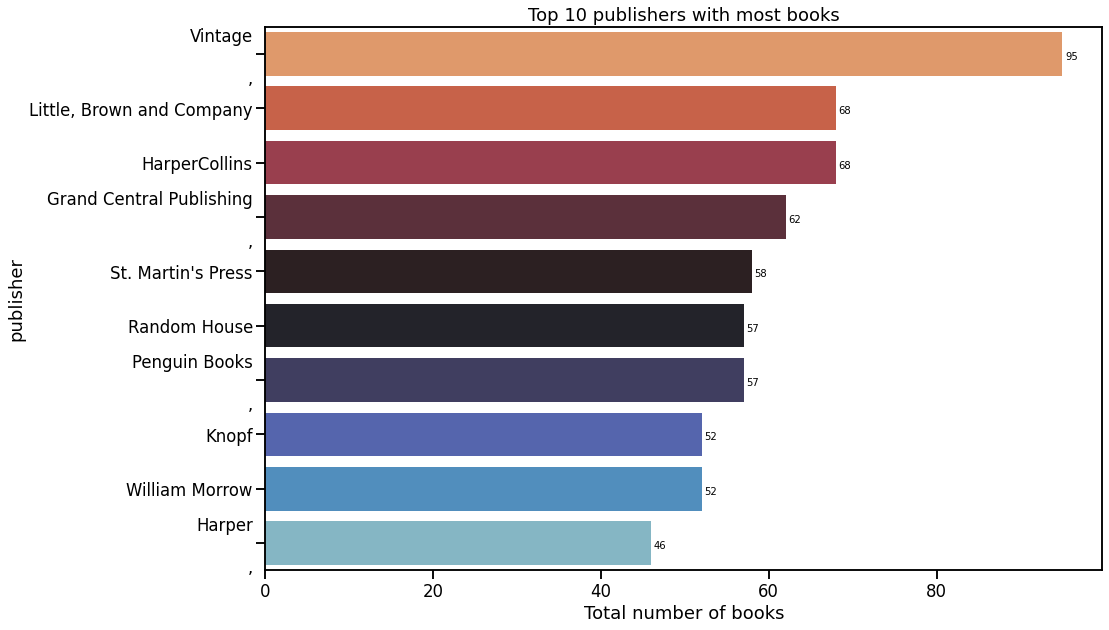

In [10]:
# Pembuatan plot top 10 publishers
sns.set_context('talk')
plt.figure(figsize=(15,10))
ax = sns.barplot(df_top_publishers['title'], df_top_publishers.index, palette='icefire_r')
ax.set_title("Top 10 publishers with most books")
ax.set_xlabel("Total number of books")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 10, color = 'k')

### Visualisasi persebaran genre

Melihat persebaran genre dari buku buku yang ada

In [11]:
df_visual_genres = df_book_list.groupby('genre')['title'].count().reset_index().sort_values('title', ascending=False).head(10)
df_visual_genres

,genre,title
42,Fiction,1654
40,Fantasy,1556
112,nan,999
71,Nonfiction,783
111,Young Adult,709
49,Historical,657
66,Mystery,467
88,Romance,434
90,Science Fiction,346
50,History,322


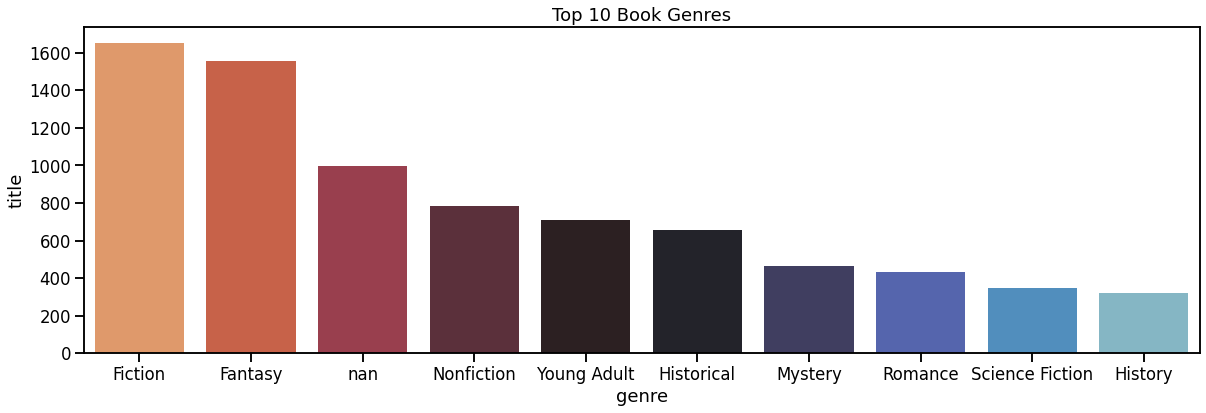

In [12]:
# Pembuatan diagram batang persebaran genre buku
plt.figure(figsize=(20,6))
plt.title('Top 10 Book Genres')
sns.barplot(x="genre", y="title", data=df_visual_genres, palette='icefire_r')
plt.show()

# **Data Preparation**

Langkah langkah yang dilakukan : 
* Menghilangkan null values
* Menghilangkan data dengan genre 'nan'
* Menghilangkan data duplikat
* One-Hot Encoding Proses ini digunakan untuk cosine similarity. Pertama saya membuat one hot encoding pada genre karena setiap film mempunyai jumlah genre yang berbeda dan genre yang bervariasi. Saya membuat kolom baru untuk setiap nilai genre yang terdapat dalam kolom genres.

Dari diagram tersebut, kita dapat informasi bahwa terdapat hampir 1000 buku yang tidak memiliki genre (nan). Oleh karena itu, perlu dilakukan penghapusan null values

### Penghapusan null values

In [13]:
df_book_list['genre'].dropna(axis=0, inplace=True)
df_book_list['title'].dropna(axis=0, inplace=True)

# Penghapusan buku dengan kategori nan
df_book_list.drop(df_book_list.loc[df_book_list['genre']== 'nan'].index, inplace=True)
print("Setelah penghapusan null values : {}".format(df_book_list.shape)) 

Setelah penghapusan null values : (9019, 14)


### Penghapusan data duplikat

In [14]:
df_book_list.drop_duplicates(subset=['title'], keep='first', inplace=True)
print("Setelah penghapusan duplikat data : {}".format(df_book_list.shape)) 

Setelah penghapusan duplikat data : (8140, 14)


In [15]:
check_duplicates = df_book_list[df_book_list.duplicated()]
print(check_duplicates)

Empty DataFrame
Columns: [id, title, series, author, book_link, genre, date_published, publisher, num_of_page, lang, review_count, rating_count, rate, award]
Index: []


### Pemilihan fitur yang signifikan dalam Content Based Filtering

In [16]:
df_book_cleaned = df_book_list[['title', 'rate', 'genre', 'id']]
df_book_cleaned.head()

,title,rate,genre,id
0,The Martian,4.40,Science Fiction,0
1,Under the Banner of Heaven: A Story of Violent...,3.98,Nonfiction,1
2,Cutting for Stone,4.29,Fiction,2
3,We Need to Talk About Kevin,4.04,Fiction,3
4,The Immortal Life of Henrietta Lacks,4.07,Nonfiction,4


# Content-Based Filtering


#### TF-IDF Vectorizer

In [17]:
# Data preparation untuk Cosine Similarity
tf = TfidfVectorizer(stop_words='english')

# Melakukan perhitungan idf pada data book
tf.fit(df_book_cleaned['genre']) 
 
# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['academic',
 'adult',
 'adventure',
 'africa',
 'american',
 'amish',
 'animals',
 'apocalyptic',
 'architecture',
 'art',
 'artificial',
 'asian',
 'autobiography',
 'aviation',
 'biography',
 'business',
 'childrens',
 'christian',
 'christianity',
 'cities',
 'classics',
 'computer',
 'contemporary',
 'crime',
 'criticism',
 'cultural',
 'culture',
 'dark',
 'death',
 'design',
 'dragons',
 'drama',
 'drink',
 'dungeons',
 'eastern',
 'economics',
 'education',
 'environment',
 'epic',
 'erotica',
 'european',
 'family',
 'fan',
 'fantasy',
 'feminism',
 'fiction',
 'folklore',
 'food',
 'football',
 'games',
 'gothic',
 'health',
 'help',
 'hi',
 'historical',
 'history',
 'holiday',
 'horror',
 'horticulture',
 'humanities',
 'humor',
 'ii',
 'inspirational',
 'intelligence',
 'labor',
 'language',
 'leadership',
 'lgbt',
 'literature',
 'marriage',
 'media',
 'medical',
 'music',
 'mystery',
 'mythology',
 'neurodiversity',
 'new',
 'nonfiction',
 'north',
 'northern',
 'novels'

#### Transform data

In [18]:
tfidf_matrix = tf.fit_transform(df_book_cleaned['genre']) 
tfidf_matrix.shape

(8140, 119)

#### Proses Perhitungan Cosine Similarity

In [19]:
cosine_sim = cosine_similarity(tfidf_matrix)
print(cosine_sim.shape)
cosine_sim

(8140, 8140)


array([[1.        , 0.        , 0.52326972, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.52326972, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

#### Pembuatan Dataframe baru hasil cosine similarity

In [20]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_book_cleaned['title'],
                             columns=df_book_cleaned['title'])
print('Size dataframe:', cosine_sim_df.shape)

# Melihat similarity matrix tiap buku
cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Size dataframe: (8140, 8140)


title,"Queen of Air and Darkness (The Dark Artifices, #3)","The Likeness (Dublin Murder Squad, #2)","Thud! (Discworld, #34; City Watch #7)","Love Walked In (Love Walked In, #1)","To the Nines (Stephanie Plum, #9)","City of Souls (Signs of the Zodiac, #4)",Stories I Stole,"One Crazy Summer (Gaither Sisters, #1)",Why Fish Fart: Gross but True Things You'll Wish You Didn't Know,109 East Palace: Robert Oppenheimer and the Secret City of Los Alamos
title,,,,,,,,,,
"The Other Wes Moore: One Name, Two Fates",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Forever ME,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
We Never Asked for Wings,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"Eona: The Last Dragoneye (Eon, #2)",1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
The Man Who Broke Into Auschwitz: A True Story of World War II,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"The Way of Shadows (Night Angel, #1)",1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"Evil at Heart (Archie Sheridan & Gretchen Lowell, #3)",0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"Your Next Breath (Catherine Ling, #4)",0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Cloud of Sparrows,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Recommendation Result for Content-Based Filtering

#### Pembuatan fungsi baru untuk merekomendasikan 10 buku yang sejenis

In [21]:
def BookRecommendations(book_title, similarity_data=cosine_sim_df, 
                         items=df_book_cleaned[["id","title","genre"]], k=10):
  
    ''' Mengambil data menggunakan argpartition untuk partisi secara tidak langsung,
    sepanjang sumbu yang diberikan, kemudian dataframe diubah menjadi numpy Range 
    dengan parameter sebagai berikut (start, stop, step) '''
    index = similarity_data.loc[:, book_title].to_numpy().argpartition(
        range(-1, -k, -1)
    )

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop book_title agar nama buku yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(book_title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

#### Pengujian data dengan menggunakan buku berjudul 'Wartime Farm'.
Dapat dilihat bahwa buku 'Wartime Farm' bergenre 'History'

In [22]:
# Check data lengkap sebuah title 
find_title = df_book_cleaned[df_book_cleaned['title'] == 'Wartime Farm']
find_title

,title,rate,genre,id
5732,Wartime Farm,4.36,History,5732


#### Rekomendasi buku yang serupa dengan 'Wartime Farm'

In [23]:
book_suggestion = BookRecommendations(book_title = 'Wartime Farm')
book_suggestion

,title,id,genre
0,The Swerve: How the World Became Modern,1951,History
1,"Caught in the Revolution: Petrograd, Russia, 1...",9029,History
2,"Rough Crossings: Britain, the Slaves and the A...",9022,History
3,Cobra II: The Inside Story of the Invasion and...,6577,History
4,The Fall of Berlin 1945,1856,History
5,"Wine and War: The French, the Nazis, and the B...",8987,History
6,Born Fighting: How the Scots-Irish Shaped America,6544,History
7,Napoleon: A Life,1920,History
8,"The Devil's Chessboard: Allen Dulles, the CIA,...",6617,History
9,The Republic of Pirates: Being the True and Su...,8978,History
